Use CMap on the LINC1000 data set to rank drugs and other perturbations based on their similarity to the transcriptomic signature of Alzheimer's disease.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import attila_utils

## Analysis with Sudhir's results
### Sudhir's CMap LINCS1000 results

In [2]:
fpath = '../../resources/CMap/sudhir-varma/LINCS1000.results.xlsx'
#fpath = '../../results/2021-10-04-CMap-discussion/from-sudhir/LINCS1000.results.xlsx'
sudhir = pd.read_excel(fpath, 'lincs1000.result')
sudhir

,id,Perturbation type,Perturbation type detail,name,description,target,belongs_to,PC3,VCAP,A375,A549,HA1E,HCC515,HT29,MCF7,HEPG2,summary
0,CGS001-2617,KD,Gene-knockdown,GARS,"Aminoacyl tRNA synthetases / Class II, glycyl-...",NaN,Aminoacyl tRNA synthetases class II LOF,-99.66,NaN,-99.94,NaN,-94.59,NaN,46.19,-98.52,-26.25,-99.89
1,CGS001-55657,KD,Gene-knockdown,ZNF692,"Zinc fingers, C2H2-type, zinc finger protein 692",NaN,NaN,-67.11,32.48,-99.66,-50.60,0.00,-99.97,-82.15,NaN,-99.82,-99.89
2,CGS001-9638,KD,Gene-knockdown,FEZ1,fasciculation and elongation protein zeta 1 (z...,NaN,NaN,47.54,79.43,-89.22,-98.91,-98.48,-80.29,NaN,69.55,-99.88,-99.87
3,CGS001-132,KD,Gene-knockdown,ADK,"Adenosine turnover, adenosine kinase",NaN,NaN,-99.87,49.49,-89.48,50.10,-75.77,NaN,-81.86,-98.51,-99.62,-99.76
4,CGS001-79796,KD,Gene-knockdown,ALG9,Dolichyl D-mannosyl phosphate dependent mannos...,NaN,NaN,0.00,NaN,-99.85,-99.45,0.00,NaN,0.00,78.66,-98.27,-99.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8964,CGS001-22827,KD,Gene-knockdown,PUF60,"RNA binding motif (RRM) containing, poly-U bin...",NaN,NaN,0.00,50.14,35.01,99.26,94.10,95.13,98.90,98.86,98.57,99.66
8965,CGS001-10247,KD,Gene-knockdown,HRSP12,heat-responsive protein 12,NaN,NaN,72.96,NaN,98.66,NaN,96.02,-80.00,87.67,98.40,99.29,99.74
8966,CGS001-55746,KD,Gene-knockdown,NUP133,nucleoporin 133kDa,NaN,"Minor histocompatibility antigens LOF, Nucleop...",NaN,45.23,98.71,99.03,99.28,83.13,97.27,99.07,98.75,99.76
8967,CGS001-2101,KD,Gene-knockdown,ESRRA,"Estrogen-related receptors, estrogen-related r...",NaN,NaN,87.47,0.00,99.49,99.79,99.98,NaN,0.00,96.69,96.97,99.84


Load results of v1 of the network proximity based DrugBank screen:

In [3]:
fpath = '../../results/2021-09-28-drugbank-screen-v1/knowledge-approved-sorted-extended.csv'
dbscreen = pd.read_csv(fpath, index_col='name')
#dbscreen = pd.read_csv(fpath, index_col='drugbank_id')
dbscreen.head()

,drugbank_id,rank,groups,symbol,hgnc_id,d,avg_d_H0,sdev_d_H0,z,p,symbols,n_targets,agora_genes,sum_agora_nomin,avg_agora_nomin,sum_sq_agora_nomin,avg_sq_agora_nomin
name,,,,,,,,,,,,,,,,,
Chlorpheniramine,DB01114,1,approved,HRH1|SLC6A4|SLC6A2|SLC6A3,HGNC:5182|HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.963500,0.167460,-5.753623,4.367536e-09,"{'SLC6A2', 'SLC6A4', 'SLC6A3', 'HRH1'}",4,set(),0,0.0,0,0.0
Venlafaxine,DB00285,2,approved,SLC6A4|SLC6A2|SLC6A3,HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.957000,0.183291,-5.221217,8.887556e-08,"{'SLC6A2', 'SLC6A4', 'SLC6A3'}",3,set(),0,0.0,0,0.0
Nomifensine,DB04821,3,approved|withdrawn,SLC6A2|SLC6A3|MAOB|MAOA|MPO|SLC6A4|SLC18A2,HGNC:11048|HGNC:11049|HGNC:6834|HGNC:6833|HGNC...,1.285714,1.998143,0.138566,-5.141426,1.363308e-07,"{'SLC18A2', 'MAOA', 'SLC6A4', 'SLC6A2', 'MAOB'...",7,set(),0,0.0,0,0.0
Duloxetine,DB00476,4,approved,SLC6A4|SLC6A2|SLC6A3,HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.954000,0.187070,-5.099701,1.700955e-07,"{'SLC6A2', 'SLC6A4', 'SLC6A3'}",3,set(),0,0.0,0,0.0
Desvenlafaxine,DB06700,5,approved|investigational,SLC6A2|SLC6A4|SLC6A3,HGNC:11048|HGNC:11050|HGNC:11049,1.000000,1.951000,0.187792,-5.064126,2.051396e-07,"{'SLC6A2', 'SLC6A4', 'SLC6A3'}",3,set(),0,0.0,0,0.0


About half of the perturbations have two or more replicates in the LINCS1000 CMap results

['named-figure/sudhir-perturbations-replicates.png',
 'named-figure/sudhir-perturbations-replicates.pdf']

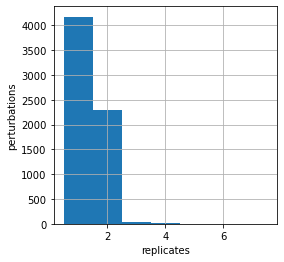

In [4]:
sudhir['name1'] = sudhir.name.str.capitalize()
sudhir_avg = sudhir.groupby('name1').mean()
fig, ax = plt.subplots(figsize=(4, 4))
vc = sudhir['name1'].value_counts()
vc.hist(ax=ax, bins=np.arange(0.5, vc.max() + 1))
ax.set_ylabel('perturbations')
ax.set_xlabel('replicates')
attila_utils.savefig(fig, 'sudhir-perturbations-replicates')

Get approved drugs shared by `dbscreen` and `lincs` 

In [5]:
common_drugs = list(set(dbscreen.index).intersection(set(sudhir_avg.index)))
common_drugs.sort()
'{} of {} approved DrugBank drugs are in LINCS1000'.format(len(common_drugs), len(dbscreen))

'625 of 1605 approved DrugBank drugs are in LINCS1000'

['named-figure/sudhir-hist-summary.png',
 'named-figure/sudhir-hist-summary.pdf']

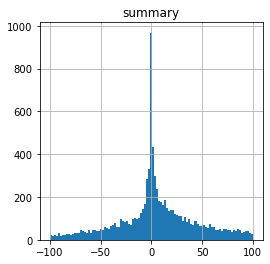

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
sudhir.hist(column='summary', ax=ax, bins=101)
attila_utils.savefig(fig, 'sudhir-hist-summary')

### Regressing LINCS summary score on network based rank

In [7]:
sel_cols = ['drugbank_id', 'groups', 'symbol', 'rank', 'z', 'p']
dbscreen['name1'] = dbscreen.index
dbscreen_sudhir = pd.merge(dbscreen[sel_cols + ['name1']], sudhir, on='name1', how='inner')

['named-figure/sudhir-lincs-rank.png', 'named-figure/sudhir-lincs-rank.pdf']

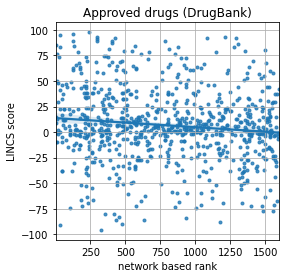

In [8]:
def plot_ols_dbscreen_lincs(merged=dbscreen_sudhir, x='rank', y='summary'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    g = sns.regplot(x=x, y=y, data=merged, fit_reg=True, ax=ax, marker='.')
    ax.set_xlabel('network based rank')
    ax.set_ylabel('LINCS score')
    ax.grid(True)
    ax.set_title('Approved drugs (DrugBank)')
    return((fig, ax))

fig, ax = plot_ols_dbscreen_lincs(dbscreen_sudhir)
attila_utils.savefig(fig, 'sudhir-lincs-rank')

In [9]:
def fit_ols_dbscreen_lincs(merged=dbscreen_sudhir, x='rank', y='summary'):
    ols_fit = smf.ols(y + ' ~ ' + x, data=merged).fit()
    val = pd.DataFrame({'beta hat': ols_fit.params[x], 'beta stderr': np.sqrt(ols_fit.cov_params().loc[x, x]), 'pvalue': ols_fit.pvalues[x]}, index=['fit results'])
    return(val)

fit_ols_dbscreen_lincs(dbscreen_sudhir)

,beta hat,beta stderr,pvalue
fit results,-0.008918,0.00261,0.000664


### Regressing network based rank on LINCS summary score

Here we swap the response and the single explanatory variable.

['named-figure/sudhir-rank-lincs.png', 'named-figure/sudhir-rank-lincs.pdf']

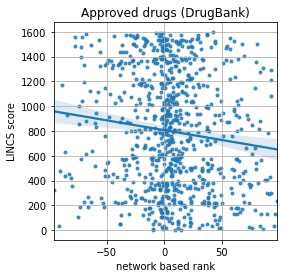

In [10]:
fig, ax = plot_ols_dbscreen_lincs(dbscreen_sudhir, x='summary', y='rank')
attila_utils.savefig(fig, 'sudhir-rank-lincs')

The scale of $\beta$ is different but the $p$ value is the same as

In [11]:
fit_ols_dbscreen_lincs(dbscreen_sudhir, x='summary', y='rank')

,beta hat,beta stderr,pvalue
fit results,-1.589697,0.465193,0.000664


### Regressing average LINCS summary score on network based rank

Here we average the LINCS summary score over all replicates for each drug.  Thus we lose data points.

In [12]:
dbscreen_sudhir_avg = pd.concat([dbscreen[sel_cols], sudhir_avg], axis=1, join='inner')

['named-figure/sudhir-avglincs-rank.png',
 'named-figure/sudhir-avglincs-rank.pdf']

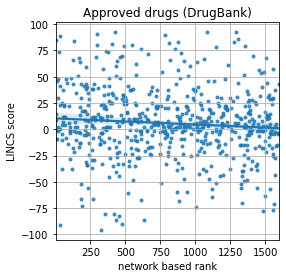

In [13]:
fig, ax = plot_ols_dbscreen_lincs(dbscreen_sudhir_avg)
attila_utils.savefig(fig, 'sudhir-avglincs-rank')

In [14]:
fit_ols_dbscreen_lincs(merged=dbscreen_sudhir_avg)

,beta hat,beta stderr,pvalue
fit results,-0.005852,0.002795,0.036702


### Conclusion:

There is an expected increase of CMap summary score with higher rank.

## Analysis with my LINCS results
### My LINCS query

We use the [query tool](https://clue.io/query) of the CMap portal [clue.io](https://clue.io).  (There is an alternative tool by the [Ma'ayanlab](https://maayanlab.cloud/l1000cds2/#/index), however that only outputs the top 50 perturbations.)  The input data are up and down regulated genes in AD compiled by Sudhir Varma using multiple GEO datasets and an R script calculating a FDR adjusted p value for each gene's differential expression test.  The number of genes in each set corresponds to the upper size limit of gene sets for CMap.

In [15]:
%%bash
cd ~/CTNS/resources/CMap/sudhir-varma/
echo "$(wc -l up.genes.txt) up regulated genes, including:"
head -n3 up.genes.txt
echo "$(wc -l down.genes.txt) up regulated genes, including:"
head -n3 down.genes.txt

     150 up.genes.txt up regulated genes, including:
NACC2
SNRNP48
FOXF1
     149 down.genes.txt up regulated genes, including:
GALNT17
SCG5
MRPL14


### My LINCS results

After inspection of the tarball downloaded from [here](https://s3.amazonaws.com/data.clue.io/api/attila.jones@nih.gov/results/Oct_04_2021/my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248/my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248.tar.gz)

In [16]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls

my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248
my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248.tar.gz
query-1


Note that `query-1` is just a symlink to `my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248`

In [17]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls query-1

arfs
down.gmt
gsea
matrices
ncs.gct
query_config.yaml
up.gmt


### arfs

In [18]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls -R query-1/arfs/

TAG
index.txt

query-1/arfs//TAG:
query_result.gct


In [19]:
fpath = '../../results/2021-10-04-CMap-discussion/query-1/arfs/TAG/query_result.gct'
lincs = pd.read_csv(fpath, sep='\t', skiprows=[0, 1, 3], na_values='-666')#.drop('1', axis=1)
lincs

/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,pert_id,pert_iname,cell_iname,pert_type,pert_idose,pert_itime,nsample,ss_ngene,cc_q75,...,qc_pass,is_hiq,is_ncs_sig,is_exemplar_sig,is_null_sig,moa,target_name,raw_cs,fdr_q_nlog10,norm_cs
0,KDB008_HEPG2_96H:TRCN0000050256:-666,TRCN0000050256,BPHL,HEPG2,trt_sh,NaN,96 h,4,214,0.55,...,1,0.0,1,1,0,NaN,NaN,0.5032,3.4284,1.9937
1,KDC006_PC3_96H:TRCN0000059426:-666,TRCN0000059426,ALB,PC3,trt_sh,NaN,96 h,2,171,0.54,...,1,0.0,1,1,0,NaN,NaN,0.4922,2.8711,1.9501
2,KDB006_HT29_96H:TRCN0000007624:-666,TRCN0000007624,BTG2,HT29,trt_sh,NaN,96 h,4,219,0.53,...,1,0.0,1,1,0,NaN,NaN,0.4817,2.6436,1.9086
3,PAC021_U2OS_6H:BRD-K55311609-001-01-3:10.1092,BRD-K55311609,BRD-K55311609,U2OS,trt_cp,10 uM,6 h,3,55,0.15,...,1,0.0,1,1,0,NaN,NaN,0.4769,2.5694,1.8897
4,KDB009_A549_96H:TRCN0000029342:-666,TRCN0000029342,CORO1A,A549,trt_sh,NaN,96 h,3,155,0.55,...,1,0.0,1,1,0,NaN,NaN,0.4762,2.5593,1.8868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423417,KDD003_VCAP_120H:TRCN0000007363:-666,TRCN0000007363,USP9X,VCAP,trt_sh,NaN,120 h,3,131,0.38,...,1,0.0,1,1,0,NaN,NaN,-0.4565,15.6536,-1.8270
423418,KDC004_PC3_96H:TRCN0000010079:-666,TRCN0000010079,ADK,PC3,trt_sh,NaN,96 h,3,56,0.46,...,1,0.0,1,1,0,NaN,NaN,-0.4589,15.6536,-1.8369
423419,KDD007_MCF7_96H:TRCN0000016723:-666,TRCN0000016723,ZNF426,MCF7,trt_sh,NaN,96 h,3,189,0.61,...,1,0.0,1,1,0,NaN,NaN,-0.4597,15.6536,-1.8398
423420,KDB002_HEPG2_96H:TRCN0000234705:-666,TRCN0000234705,HIGD2A,HEPG2,trt_sh,NaN,96 h,3,132,0.34,...,1,0.0,1,1,0,NaN,NaN,-0.4651,15.6536,-1.8616


Some perturbations are replicated several hundred times while many only once.

Manual inspection reveals that the replicates correspond to:
* multiple (many) cell types/lines
* multiple doses
* multiple exposure times

In [20]:
sel_cols1 = ['pert_iname', 'cell_iname', 'pert_type', 'pert_idose', 'pert_itime', 'nsample', 'raw_cs', 'fdr_q_nlog10', 'norm_cs']
df = lincs.loc[lincs['pert_iname'] == 'afatinib', sel_cols1]
df.sort_values(['cell_iname'])

,pert_iname,cell_iname,pert_type,pert_idose,pert_itime,nsample,raw_cs,fdr_q_nlog10,norm_cs
137549,afatinib,A375,trt_cp,0.04 uM,24 h,2,0.1825,0.0173,0.7233
95457,afatinib,A375,trt_cp,2.22 uM,24 h,2,0.2285,0.2012,0.9053
180350,afatinib,A549,trt_cp,10 uM,24 h,2,0.0000,-0.0000,0.0000
195787,afatinib,A549,trt_cp,2.22 uM,24 h,2,0.0000,-0.0000,0.0000
7421,afatinib,ASC,trt_cp,10 uM,24 h,4,0.3326,1.5342,1.3178
144138,afatinib,BJAB,trt_cp,10 uM,4 h,3,0.0000,-0.0000,0.0000
180364,afatinib,BT20,trt_cp,1.11 uM,24 h,2,0.0000,-0.0000,0.0000
37692,afatinib,HA1E,trt_cp,2.22 uM,24 h,2,0.2776,0.7655,1.0998
116689,afatinib,HA1E,trt_cp,10 uM,24 h,3,0.2108,0.1007,0.8353
144148,afatinib,HBL1,trt_cp,2.5 uM,24 h,3,0.0000,-0.0000,0.0000


['named-figure/lincs-perturbations-replicates.png',
 'named-figure/lincs-perturbations-replicates.pdf']

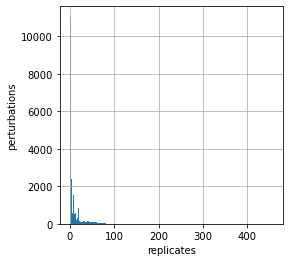

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
lincs['name1'] = lincs.pert_iname.str.capitalize()
vc = lincs['name1'].value_counts()
vc.hist(ax=ax, bins=np.arange(0.5, vc.max() + 1))
ax.set_ylabel('perturbations')
ax.set_xlabel('replicates')
attila_utils.savefig(fig, 'lincs-perturbations-replicates')

### Regression analysis

We see that, unlike the `summary` score variable in Sudhir's results, the `norm_cs` and `raw_cs` variables in my results are strongly trimodal.

['named-figure/lincs-hist-norm_cs.png', 'named-figure/lincs-hist-norm_cs.pdf']

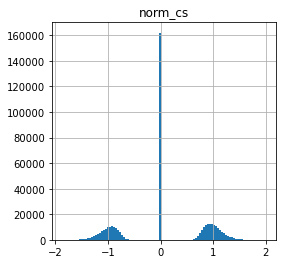

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
lincs.hist(column='norm_cs', ax=ax, bins=101, density=False)
attila_utils.savefig(fig, 'lincs-hist-norm_cs')

['named-figure/lincs-hist-raw_cs.png', 'named-figure/lincs-hist-raw_cs.pdf']

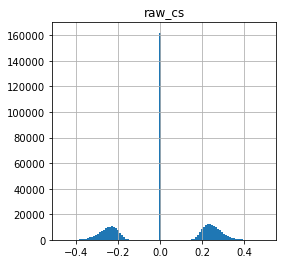

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
lincs.hist(column='raw_cs', ax=ax, bins=101, density=False)
attila_utils.savefig(fig, 'lincs-hist-raw_cs')

In [24]:
dbscreen_lincs = pd.merge(dbscreen[sel_cols + ['name1']], lincs, on='name1', how='inner')

### Inference based on t-test

In [25]:
lincs_groups = ['low LINCS score', 'high LINCS score']
ranks_a = dbscreen_lincs.loc[dbscreen_lincs.norm_cs < 0, 'rank']
ranks_b = dbscreen_lincs.loc[dbscreen_lincs.norm_cs > 0, 'rank']
stats.ttest_ind(ranks_a, ranks_b)

Ttest_indResult(statistic=3.9544788695249466, pvalue=7.72419470090229e-05)

['named-figure/lincs-rank-boxplot.png', 'named-figure/lincs-rank-boxplot.pdf']

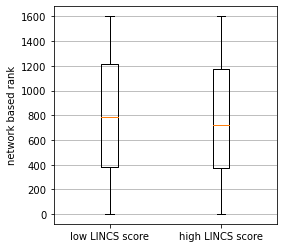

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot([ranks_a, ranks_b])
ax.set_xticklabels(lincs_groups)
ax.grid(True, axis='y')
ax.set_ylabel('network based rank')
attila_utils.savefig(fig, 'lincs-rank-boxplot')

['named-figure/lincs-rank-barplot.png', 'named-figure/lincs-rank-barplot.pdf']

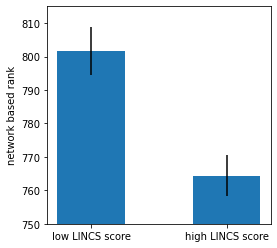

In [27]:
ranks_avg = [np.mean(y) for y in [ranks_a, ranks_b]]
ranks_sem = [np.std(y) / np.sqrt(len(y)) for y in [ranks_a, ranks_b]]
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(x=[0, 1], height=ranks_avg, yerr=ranks_sem, width=0.5)
ax.set_xticks([0, 1])
ax.set_xticklabels(lincs_groups)
ax.set_ylabel('network based rank')
ax.set_ylim([750, 815])
attila_utils.savefig(fig, 'lincs-rank-barplot')

### Inference based on linear model

Even though the fit looks ugly, the inference on $\beta$ gives even stronger result than the t-test.

['named-figure/lincs-rank.png', 'named-figure/lincs-rank.pdf']

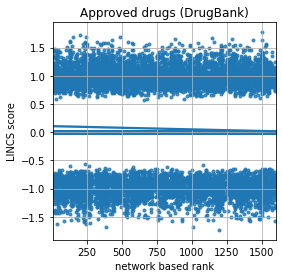

In [28]:
fig, ax = plot_ols_dbscreen_lincs(dbscreen_lincs, x='rank', y='norm_cs')
attila_utils.savefig(fig, 'lincs-rank')

In [29]:
fit_ols_dbscreen_lincs(dbscreen_lincs, x='rank', y='norm_cs')

,beta hat,beta stderr,pvalue
fit results,-0.000057,0.000014,0.000028


The above results are stronger than the t-test due to the data points with $\text{norm_cs} = 0$.  Removing these points gives a less significant result than the previous linear model fit.  However, the result is still slightly more significant than the t-test, indicating that including the exact value of $\text{norm_cs}$ contains information on network based rank in addition to the indicator variable $\mathbf{1}_{\text{norm_cs} < 0}$.

In [30]:
fit_ols_dbscreen_lincs(dbscreen_lincs.loc[dbscreen_lincs.norm_cs != 0], x='rank', y='norm_cs')

,beta hat,beta stderr,pvalue
fit results,-0.000089,0.000022,0.000052


### Conclusion

Even though the fit looks ugly, the inference on $\beta$, the effect of network based rank on LINCS score is qualitatively the same as for Sudhir's LINCS results.

## Odds and ends
### gsea

In [31]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls -R query-1/gsea/

TAG

query-1/gsea//TAG:
arfs
config.yaml
matrices
success.txt

query-1/gsea//TAG/arfs:
NORM_CS
index.txt

query-1/gsea//TAG/arfs/NORM_CS:
gsea_result.gct

query-1/gsea//TAG/matrices:
cs.gctx
dn.gmt
fdr_qvalue.gctx
nes.gctx
up.gmt


In [32]:
fpath = '../../results/2021-10-04-CMap-discussion/query-1/gsea/TAG/arfs/NORM_CS/gsea_result.gct'
df = pd.read_csv(fpath, sep='\t', skiprows=[0, 1, 3], na_values='-666')
df

,id,set_type,set_size,src_set_size,num_hiq_sig,pct_hiq_sig,num_uniq_pert,pct_src_pert,src_set_id,cell_iname,pert_type,is_filtered_set,desc,raw_cs,fdr_q_nlog10,norm_cs
0,MTOR_INHIBITOR:TRT_CP,MOA_CLASS,706,37,403,57.082153,30,81.081081,MTOR_INHIBITOR,NaN,TRT_CP,True,MTOR_INHIBITOR:trt_cp,0.6278,15.6536,2.8336
1,CP_MTOR_INHIBITOR:TRT_CP,PCL,528,16,312,59.090909,16,100.000000,CP_MTOR_INHIBITOR,NaN,TRT_CP,True,CP_MTOR_INHIBITOR:trt_cp,0.6388,3.1563,2.8169
2,CP_PI3K_INHIBITOR:TRT_CP,PCL,465,16,268,57.634409,16,100.000000,CP_PI3K_INHIBITOR,NaN,TRT_CP,True,CP_PI3K_INHIBITOR:trt_cp,0.5731,1.8693,2.5111
3,MTOR_INHIBITOR:PC3:TRT_CP,MOA_CLASS,38,37,28,73.684211,26,70.270270,MTOR_INHIBITOR,PC3,TRT_CP,True,MTOR_INHIBITOR:PC3:trt_cp,0.7512,1.8196,2.4720
4,MTOR_INHIBITOR:HA1E:TRT_CP,MOA_CLASS,37,37,27,72.972973,26,70.270270,MTOR_INHIBITOR,HA1E,TRT_CP,True,MTOR_INHIBITOR:HA1E:trt_cp,0.7021,1.6591,2.3104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12095,BIOCARTA_P53HYPOXIA_PATHWAY:A549:TRT_OE,PATHWAY_SET,117,23,38,32.478632,14,60.869565,BIOCARTA_P53HYPOXIA_PATHWAY,A549,TRT_OE,True,BIOCARTA_P53HYPOXIA_PATHWAY:A549:trt_oe,-0.5477,1.4231,-2.1864
12096,ST_GA12_PATHWAY:HEPG2:TRT_SH.CGS,PATHWAY_SET,10,23,8,80.000000,10,43.478261,ST_GA12_PATHWAY,HEPG2,TRT_SH.CGS,True,ST_GA12_PATHWAY:HEPG2:trt_sh.cgs,-0.9369,1.4703,-2.2094
12097,CP_HDAC_INHIBITOR:TRT_CP,PCL,333,20,179,53.753754,18,90.000000,CP_HDAC_INHIBITOR,NaN,TRT_CP,True,CP_HDAC_INHIBITOR:trt_cp,-0.4931,1.4703,-2.2183
12098,KEGG_RENAL_CELL_CARCINOMA:U2OS:TRT_OE,PATHWAY_SET,39,70,13,33.333333,25,35.714286,KEGG_RENAL_CELL_CARCINOMA,U2OS,TRT_OE,True,KEGG_RENAL_CELL_CARCINOMA:U2OS:trt_oe,-0.6676,1.8717,-2.2814


### Converting BRD ID to DrugBank ID

The conversion might be difficult.  See [this](https://think-lab.github.io/d/51/) and [this](https://www.biostars.org/p/249949/) threads on old forums.

The following sheet downloaded from the [LINCS Data Portal | Small Molecules](http://lincsportal.ccs.miami.edu/SmallMolecules/catalog) might be useful for the conversion.

In [33]:
pd.read_csv('../../resources/CMap/SmallMolecule_1633383104307.csv').head()

,SM_Name,SM_LINCS_ID,SM_Alternative_Name,SM_PubChem_CID,SM_SMILES_Parent,SM_SMILES_Batch,SM_InChi_Parent,SM_Molecular_Mass,MOLECULAR_FORMULA,SM_ChEBI_ID
0,Pyridoxine,LSM-5324,"Lyphomed,Hexa-Betalin,Pyridoxine HCl,PYRID-20,...",1054.0,Cc1ncc(CO)c(CO)c1O,NaN,InChI=1S/C8H11NO3/c1-5-8(12)7(4-11)6(3-10)2-9-...,169.18,C8H11NO3,"16709, 30961"
1,Vigabatrin,LSM-4959,"CPP-109,Gamma-Vinyl GABA,MDL-71754,RMI-71754,S...",5665.0,NC(CCC(=O)O)C=C,NaN,"InChI=1S/C6H11NO2/c1-2-5(7)3-4-6(8)9/h2,5H,1,3...",129.16,C6H11NO2,63638
2,AC1N8GBV,LSM-16274,"2-Furaldehyde (4-amino-5-methyl-4H-1\,2\,4-tri...",4343351.0,Cc1nnc(NN=Cc2occc2)n1N,NaN,InChI=1S/C8H10N6O/c1-6-11-13-8(14(6)9)12-10-5-...,206.20,C8H10N6O,104911
3,Formononetin,LSM-19000,"Formononetin,NSC-93360",5280378.0,COc1ccc(cc1)C2=COc3cc(O)ccc3C2=O,NaN,InChI=1S/C16H12O4/c1-19-12-5-2-10(3-6-12)14-9-...,268.26,C16H12O4,18088
4,9-Cyclopentyl-6-mercaptopurine,LSM-24332,9-Cyclopentyl-6-mercaptopurine 19487,3034494.0,Sc1ncnc2c1ncn2C3CCCC3,NaN,InChI=1S/C10H12N4S/c15-10-8-9(11-5-12-10)14(6-...,220.29,C10H12N4S,112922


In [34]:
%connect_info

{
  "shell_port": 52984,
  "iopub_port": 52985,
  "stdin_port": 52986,
  "control_port": 52988,
  "hb_port": 52987,
  "ip": "127.0.0.1",
  "key": "0913f996-90b125c6d15e1806643a1ffa",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-7180ac89-052d-4d6e-97b8-6c1ca8a1c823.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
